<center>МИНИСТЕРСТВО НАУКИ И ВЫСШЕГО ОБРАЗОВАНИЯ РОССИЙСКОЙ ФЕДЕРАЦИИ </center>
<center>ФЕДЕРАЛЬНОЕ ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ ОБРАЗОВАТЕЛЬНОЕ УЧРЕЖДЕНИЕ ВЫСШЕГО ОБРАЗОВАНИЯ </center>
<center>«НОВОСИБИРСКИЙ ГОСУДАРСТВЕННЫЙ ТЕХНИЧЕСКИЙ УНИВЕРСИТЕТ»</center>
<center>Кафедра Вычислительной техники </center>
<br>
<center> <b> <font size="5">  ОТЧЁТ </font>  </b>  </center>   
<center><font size="3">по лабораторной работе №3</font></center>
<center><font size="3">по дисциплине: «Системы искусственного интеллекта и машинное обучение» </font></center>
<br>

Выполнили студенты гр. АПИМ-25:
- Клименко К.В.
- Бадагов А.В.

Проверил: Осипенко И.В.

<center>  Новосибирск, 2025  </center>

#Цель работ

Знакомство и работа с моделью машинного обучения типа "многослойный перцептрон" для решения задачи регрессии с использованием библиотеки Tensorflow.

#Ход работы

In [ ]:
# Проверка версии и пути к выбранному интерпретатору
import sys
print(f"Версия Python - {sys.version}")
print(f"Путь к интерпретатору Python - {sys.executable}")

Версия Python - 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
Путь к интерпретатору Python - /usr/bin/python3


In [ ]:
# Python > 3.8
import pandas as pd
import numpy  as np

import sklearn
from sklearn import linear_model
from sklearn import ensemble
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import cm
import seaborn as sns
import tensorflow as tf
from IPython.display import clear_output
import plotly.graph_objects as go

##Объявление функций

Для повышения повторяемости кода и повышения уровня читаемости объявим несколько функций с уже знакомыми операциями

In [ ]:
def draw_plot(y_test, y_pred):
    plt.figure(figsize=(12,6))

    # == Диаграмма рассеяния вычисленных значений ==
    plt.subplot(121)
    plt.scatter(y_test, y_pred,  alpha=0.1, color = "#17becf")
    plt.plot(  [ np.min(y_test), np.max(y_test) ], # x1,x2
               [ np.min(y_test), np.max(y_test) ], # y1,y2
               '--',
               alpha=0.7, lw=3, color = "black")
    plt.title('Диаграмма рассеяния вычисленных значений');
    plt.xlabel('Проверочное Y')
    plt.ylabel('Вычисленное Y')
    plt.grid(True)

    # == Диаграмма рассеяния ошибок ==
    plt.subplot(122)
    plt.scatter(y_test, (y_test - y_pred)**2,  alpha=0.1, color = "#17becf")
    plt.title('Диаграмма рассеяния квадрата абсолютной ошибки')
    plt.xlabel('Проверочное Y')
    plt.ylabel('Квадрат абсолютной ошибки')
    plt.grid(True)

In [ ]:
def print_metrics(y_test, y_pred):
    mae  = metrics.mean_absolute_error(y_test, y_pred)
    mse  = metrics.mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    if len(y_test) < 2:
      y_test = y_test[0]
      y_pred = y_pred[0]
    r2 = metrics.r2_score(y_test, y_pred)

    print ("MAE : {:>9,.3f} (средняя абсолютная ошибка)".format(mae))
    print ("MSE : {:>9,.6f} (среднеквадратичная ошибка)".format(mse))
    print ("RMSE: {:>9,.6f} (кв. корень из среднеквадратичной ошибки)".format(rmse))
    print ("R2  : {:>9,.3f} (коэфф. детерминации)".format(r2))

In [ ]:
def my3dplot (  x_train: pd.DataFrame, y_train: pd.DataFrame,  isDrawTrain: bool,
                x_test:  pd.DataFrame, y_test: pd.DataFrame,    isDrawTest: bool,
                y_pred:  pd.DataFrame,            isDrawPred: bool,
                x1Name: str, x2Name: str, y_targetName: str,
                pointSize = 5,     # Размер точки
                pointTransparency  = 0.25, # Прозрачность точек графика train, test
                meshTransparency   = 0.5  # Прозрачность поверхности вычисленных значений y_pred
                ) -> None:
    """
    Отображает 3D график исходных и вычисленых точек
    x_test, y_test, x_train, y_train - обучающая и проверочная части исходной таблицы  (тип DataFrame)
    y_pred, - вычисленные значения (тип DataFrame)
    x1Name, x2Name - имя столбца для x1 и x2 (тип строковый)
    y_targetName   - имя столбца целевого    (тип строковый)
    """
    # Построить поверхность, соотвествующую вычисленным значениям
    trace_ModelPredicted = go.Mesh3d(
                       x= x_test[ x1Name ].values,
                       y= x_test[ x2Name ].values,
                       z= y_pred.reshape(-1), # <-- Вычисленные
                       name="Вычисленный",
                       opacity=meshTransparency,
                       #alphahull=1,
                       color='rgb(244,100,100)',  #  rgba(100,244,100, 0.6)
                      )

    # Построить рассеяние обучающих точек
    trace_Train = go.Scatter3d (x= x_train[ x1Name ].values, # <-- Обучающие
                                y= x_train[ x2Name ].values, # <-- Обучающие
                                z= y_train[ y_targetName ].values,     # <-- Обучающие
                                name="Обучающие",
                                mode='markers',
                                marker=dict(
                                    size=pointSize,
                                    color='#1f77b4', # Цвет точек <-- Проверочные
                                    # color=y_train[ y_targetName ].values, # Источник значений цвета <-- Обучающие
                                    # colorscale='Blues',        # Название цветовой шкалы # _r
                                    opacity=pointTransparency
                                ))

    # Построить рассеяние проверочных точек
    trace_Test = go.Scatter3d ( x= x_test[ x1Name ].values,# <-- Проверочные
                                y= x_test[ x2Name ].values,# <-- Проверочные
                                z= y_test[ y_targetName ].values,    # <-- Проверочные
                                name="Проверочные",
                                mode='markers',
                                marker=dict(
                                    size=pointSize,
                                    color='#ff7f0e', # Цвет точек <-- Проверочные
                                    # color=y_test[y_targetName].values, # Источник значений цвета <-- Проверочные
                                    # colorscale='Oranges',        # Название цветовой шкалы # _r
                                    opacity=pointTransparency
                               ))

    # Составить список элементов к отрисовке на графике
    ListForDraw = []
    if isDrawTrain: ListForDraw.append(trace_Train)
    if isDrawTest:  ListForDraw.append(trace_Test)
    if isDrawPred:  ListForDraw.append(trace_ModelPredicted)

    # Отрисовать все указанные элементы
    fig = go.Figure( data=ListForDraw)

    # Добавить подписи осей
    fig.update_layout(
        width=800,
        height=600,
        title='Завиcимость {} от ({}, {})'.format(y_targetName, x1Name, x2Name),
        scene=dict(
            xaxis_title=x1Name,
            yaxis_title=x2Name,
            zaxis_title=y_targetName,
        ),
    )
    fig.show()

In [ ]:
def printModelWeights(model):
  # Вывод структуры и значений весовых коэфф. нейросети по слоям
  for layer in model.layers:
      print(f'{"#"*100}')
      print(f"#### Имя слоя:{layer.name};  Тип слоя: {layer.__class__} ##########", end='')
      print(f"\nВид ф-ии активации слоя: {layer.get_config()['activation']}", end='')
      print(f"\nКол-во ВХодов  слоя: {layer.input.shape[1]}", end='')
      print(f"\nКол-во ВЫХодов слоя: {layer.output.shape[1]}", end='')
      if type(layer) is tf.keras.layers.Dense:
          print(f"\nКол-во нейронов слоя:    {layer.get_config()['units']}", end='')
          print(f"\n\nВесовые коэфф. weight_i_j=\n{layer.weights[0].numpy()}")
          print(f"\nВесовые коэфф. bias_i_j=\n{layer.bias.numpy()}")
      elif type(layer) is tf.keras.layers.Activation:
          pass
      print('\n')

In [ ]:
df = pd.read_csv('./df_diamond.csv',
                 sep=',',
                 header=0)
print("Размер таблицы", df.shape)
df[:5]

Размер таблицы (47327, 10)


carat  cut  color  clarity  depth  table  price     x     y     z
0   0.23    5      6        2   61.5   55.0  326.0  3.95  3.98  2.43
1   0.21    4      6        3   59.8   61.0  326.0  3.89  3.84  2.31
2   0.29    4      2        4   62.4   58.0  334.0  4.20  4.23  2.63
3   0.31    2      1        2   63.3   58.0  335.0  4.34  4.35  2.75
4   0.24    3      1        6   62.8   57.0  336.0  3.94  3.96  2.48

In [ ]:
features = [col for col in list(df.columns) if col != 'price']
target = ['price']

print(features)
print(target)

dfX = df[features]
print("Размер таблицы", dfX.shape)
dfY = df[target]
print("Размер таблицы", dfY.shape)

['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'x', 'y', 'z']
['price']
Размер таблицы (47327, 9)
Размер таблицы (47327, 1)


In [ ]:
scalerNormX = MinMaxScaler()
scalerNormX.fit(dfX)

dfXNorm = pd.DataFrame (
  data    = scalerNormX.transform(dfX), # значения ячеек    <<--
  columns = dfX.columns,           # названия столбцов
  index   = dfX.index              # идентификаторы строк
)
print("Размер таблицы", dfXNorm.shape)
dfXNorm[:5]

Размер таблицы (47327, 9)


carat   cut     color   clarity     depth     table         x         y  \
0  0.016667  1.00  0.833333  0.142857  0.457627  0.260870  0.048352  0.065359   
1  0.005556  0.75  0.833333  0.285714  0.169492  0.782609  0.035165  0.034858   
2  0.050000  0.75  0.166667  0.428571  0.610169  0.521739  0.103297  0.119826   
3  0.061111  0.25  0.000000  0.142857  0.762712  0.521739  0.134066  0.145969   
4  0.022222  0.50  0.000000  0.714286  0.677966  0.434783  0.046154  0.061002   

          z  
0  0.262211  
1  0.231362  
2  0.313625  
3  0.344473  
4  0.275064

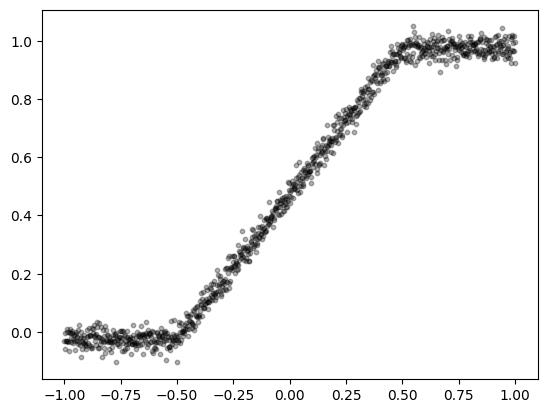

In [ ]:
N = 1000 # кол-во точек X
X = np.linspace(-1., 1., N).reshape(-1, 1) # привести массив к столбчатой структуре
noiseLevel= 0.05 # степень зашумленности
Y_noise = np.random.normal(-noiseLevel,noiseLevel,N).reshape(-1, 1)
transparencyVal = 0.3  # Прозрачность точек графика
markerSize = 10        # Размер точки графика

# Линейный с граничными значениями
c1 = int(X.size * 0.25)
c2 = int(X.size * 0.50)
c3 = X.size - c1 - c2

Y_linstep = np.concatenate([
        np.zeros( c1 ),
        np.linspace(start=0., stop=1., num=c2),
        1.0 + np.zeros(c3 )
        ],
    ).reshape(-1, 1)# привести массив к столбчатой структуре

Y_linstep= Y_linstep+Y_noise/2
plt.scatter(X, Y_linstep, s=markerSize, color="black", alpha=transparencyVal)



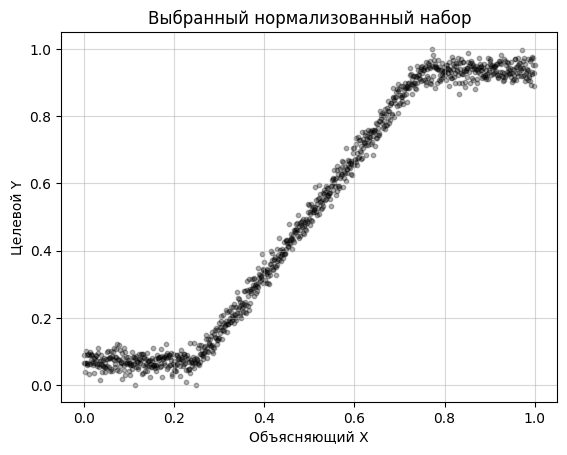

In [ ]:
x_train = X.copy().reshape(-1,1)    # привести массив к столбчатой структуре
#▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼
y_train = Y_linstep.copy().reshape(-1,1) # привести массив к столбчатой структуре
#▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲
NormalizerX_EXAMPLE = MinMaxScaler().fit(x_train)
NormalizerY_EXAMPLE = MinMaxScaler().fit(y_train)
xNorm_train = NormalizerX_EXAMPLE.transform(x_train)
yNorm_train = NormalizerY_EXAMPLE.transform(y_train)

plt.scatter(xNorm_train, yNorm_train, s=markerSize, color="black", alpha=transparencyVal)
plt.title("Выбранный нормализованный набор")
plt.ylabel("Целевой Y"); plt.xlabel("Объясняющий X");
plt.grid(True, alpha=0.5)  # Сетка.

47327
carat
cut
color
clarity
depth
table
x
y
z


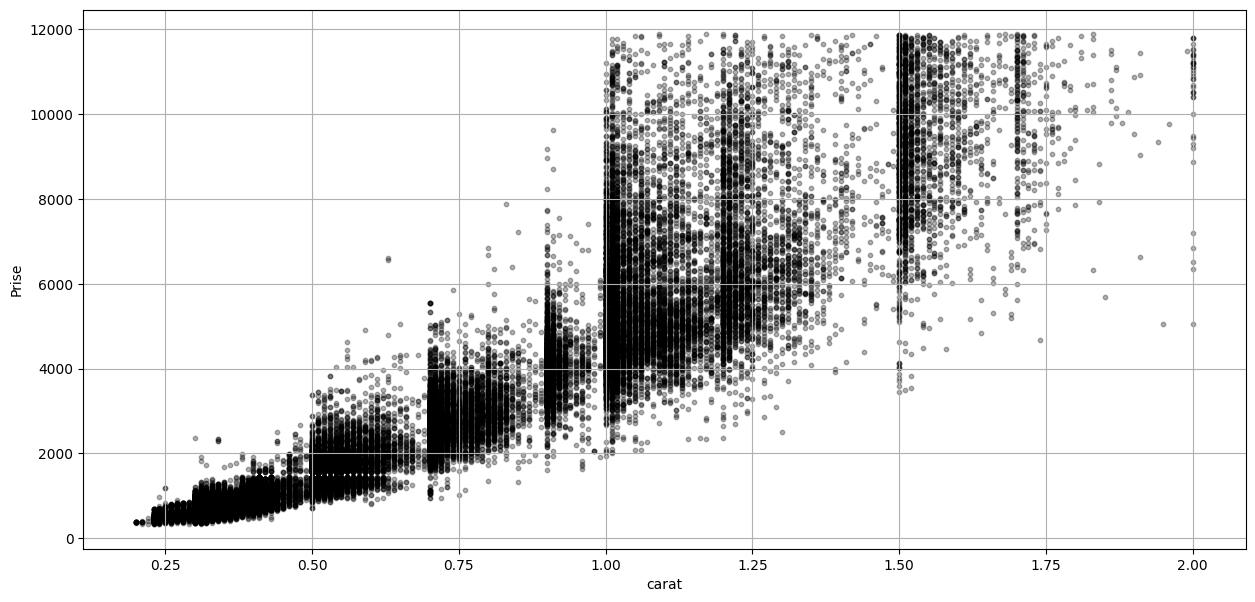

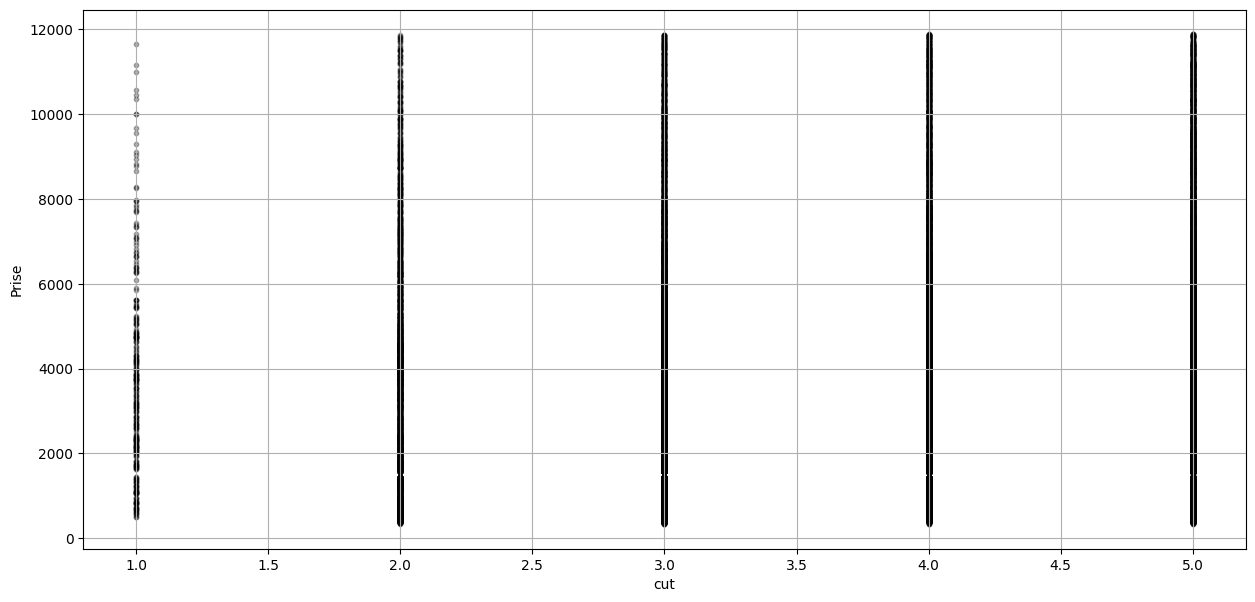

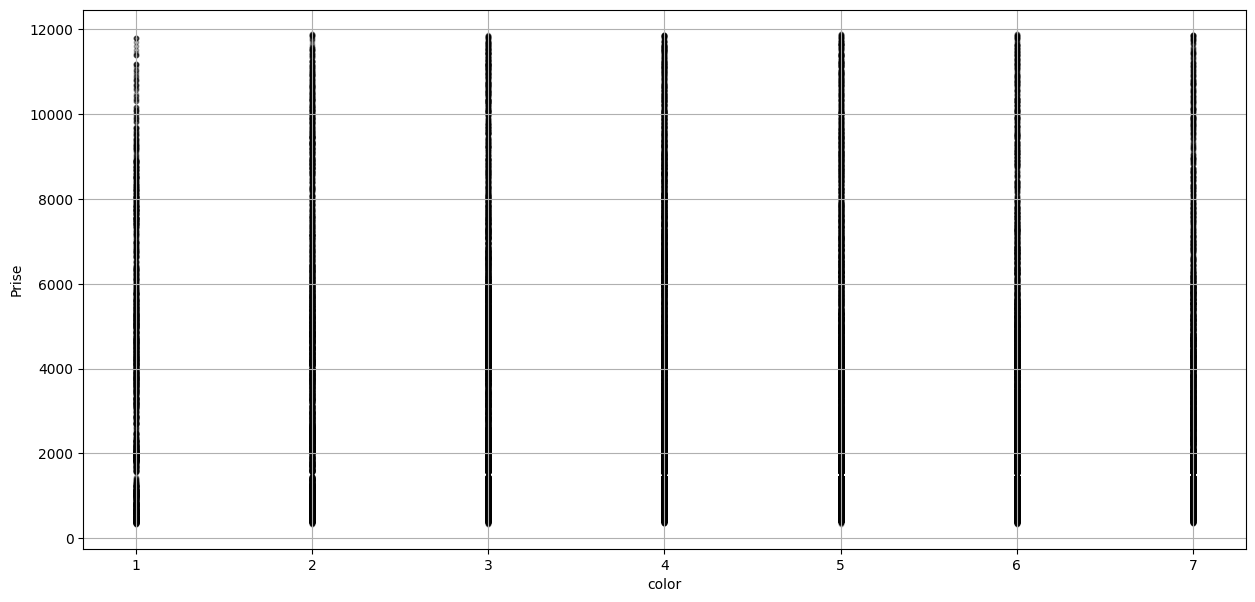

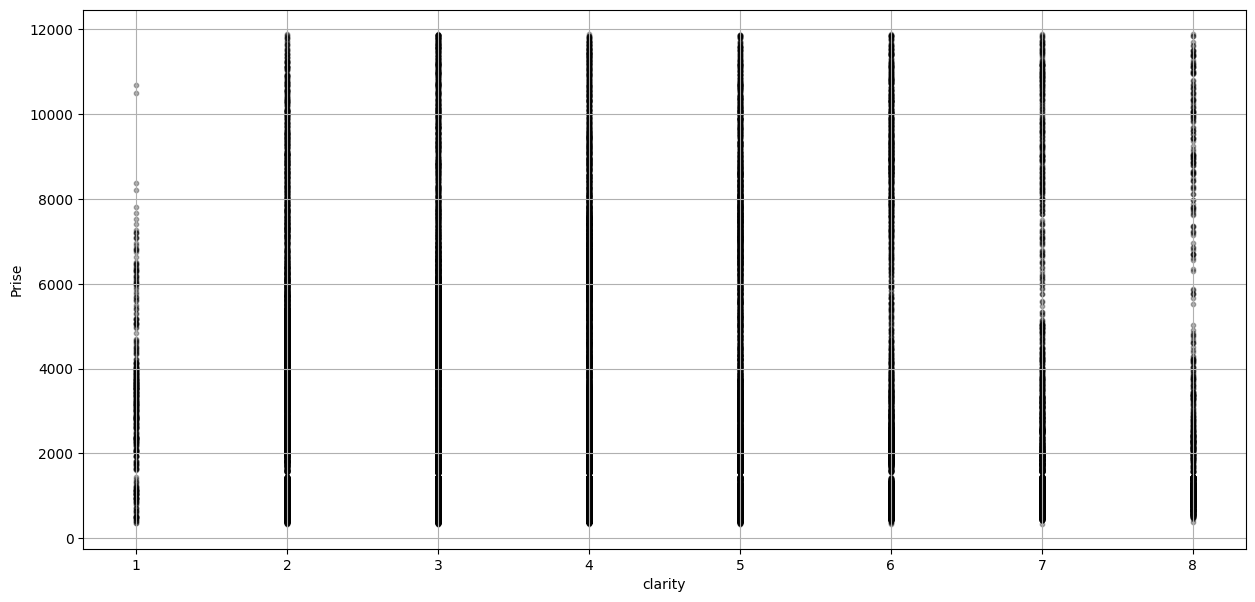

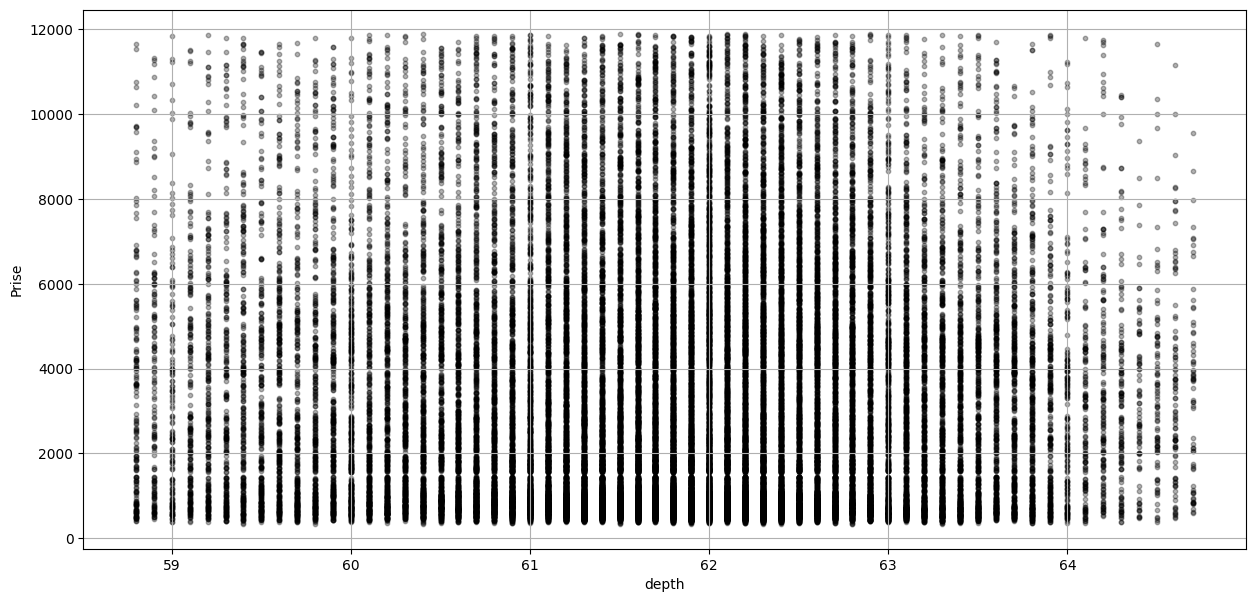

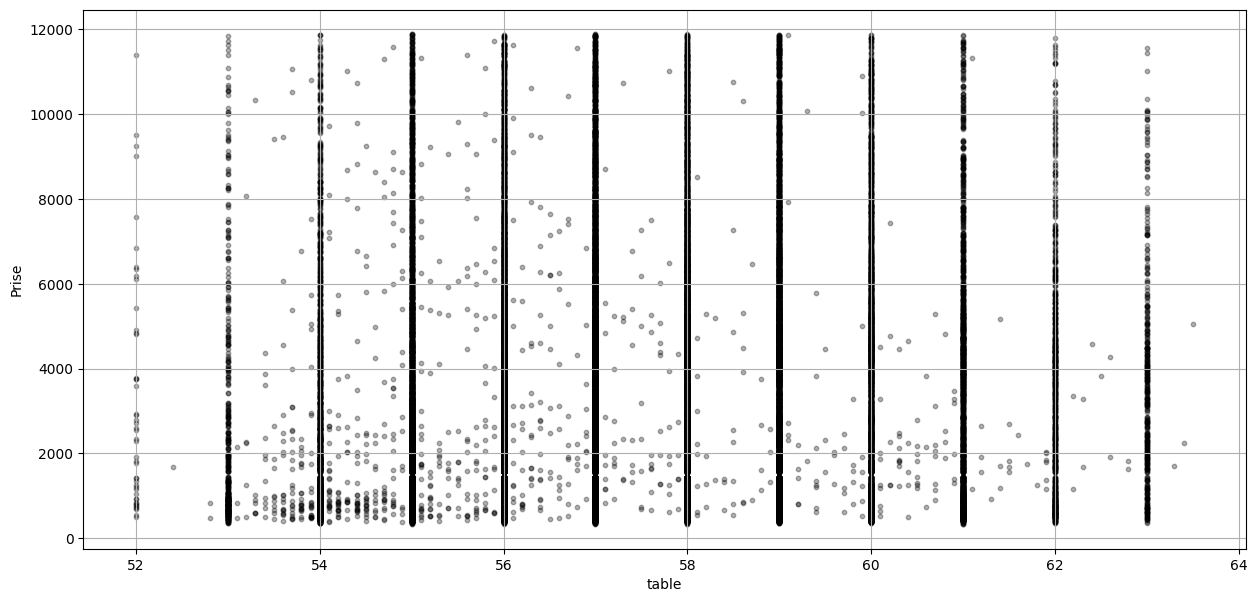

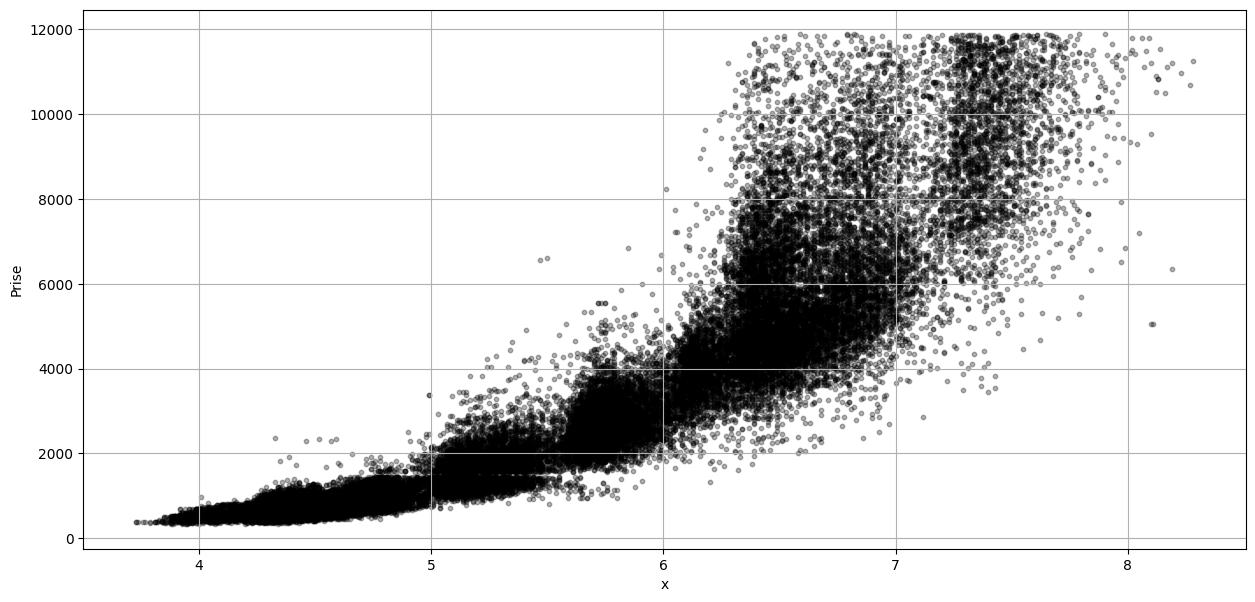

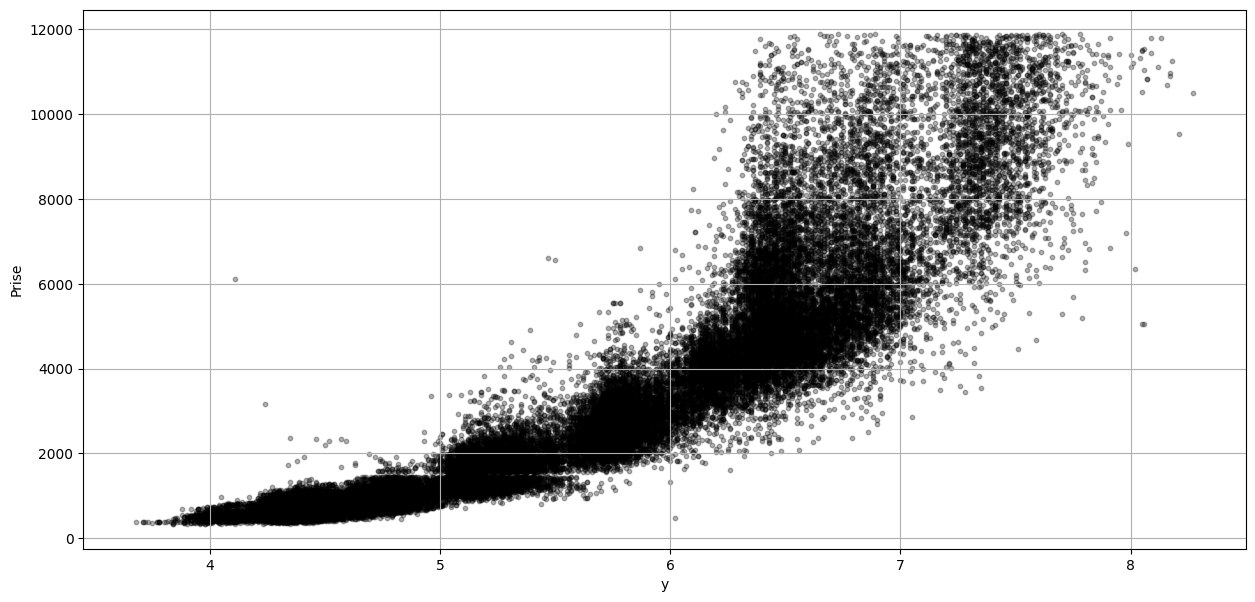

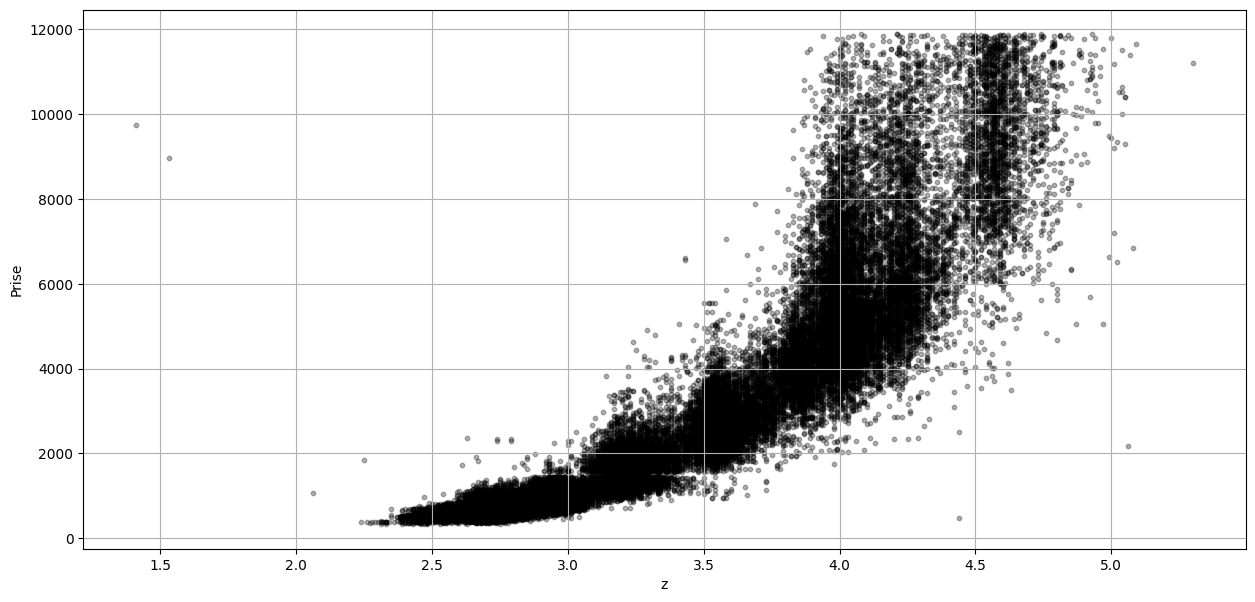

In [ ]:
transparencyVal = 0.3
markerSize = 10
print(len(dfY))
for i in features:
    print(i)
    plt.figure(figsize=(15, 7))
    plt.scatter(dfX[i], dfY, s=markerSize, color="black", alpha=transparencyVal)

    plt.xlabel(i)
    plt.ylabel('Prise')
    plt.grid(True)


In [ ]:

scalerNormY = MinMaxScaler()
scalerNormY.fit(dfY)

dfYNorm = pd.DataFrame (
  data    = scalerNormY.transform(dfY), # значения ячеек    <<--
  columns = dfY.columns,           # названия столбцов
  index   = dfY.index              # идентификаторы строк
)
print("Размер таблицы", dfYNorm.shape)
dfYNorm[:5]

Размер таблицы (47327, 1)


price
0  0.000000
1  0.000000
2  0.000692
3  0.000778
4  0.000865

##Проверка нормализации

In [ ]:
print(dfXNorm.describe().loc[["min", "max"]])
print(dfYNorm.describe().loc[["min", "max"]])

     carat  cut  color  clarity  depth  table    x    y    z
min    0.0  0.0    0.0      0.0    0.0    0.0  0.0  0.0  0.0
max    1.0  1.0    1.0      1.0    1.0    1.0  1.0  1.0  1.0
     price
min    0.0
max    1.0


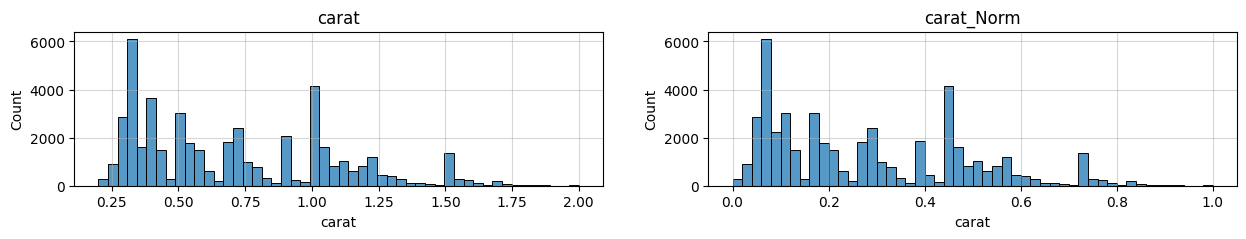

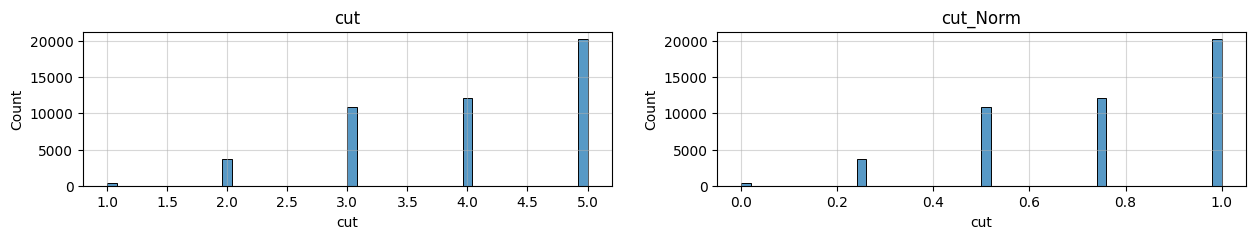

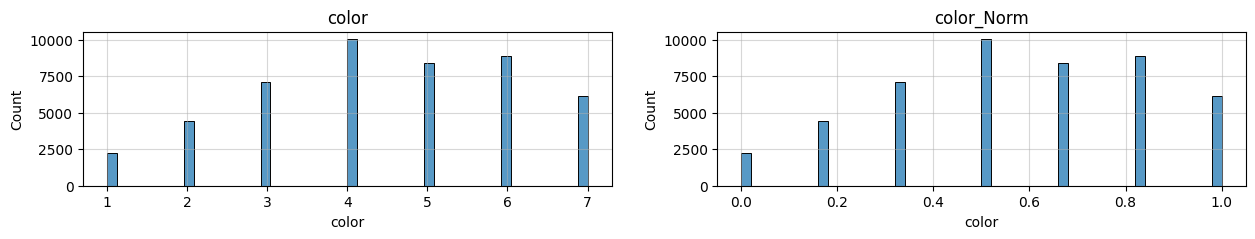

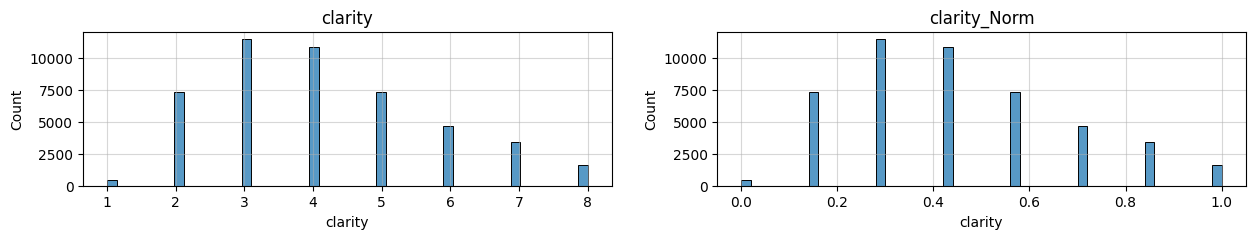

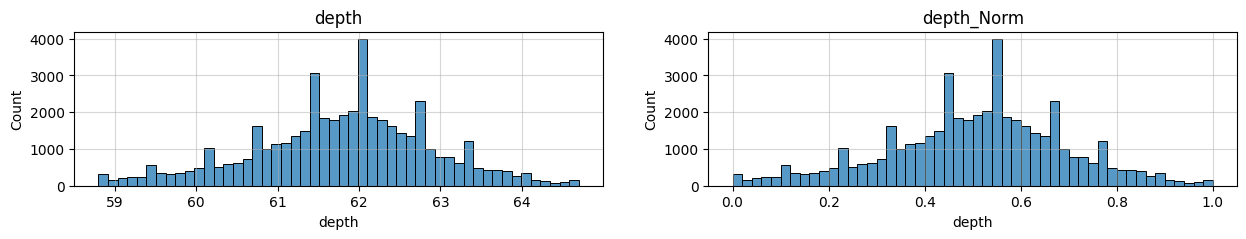

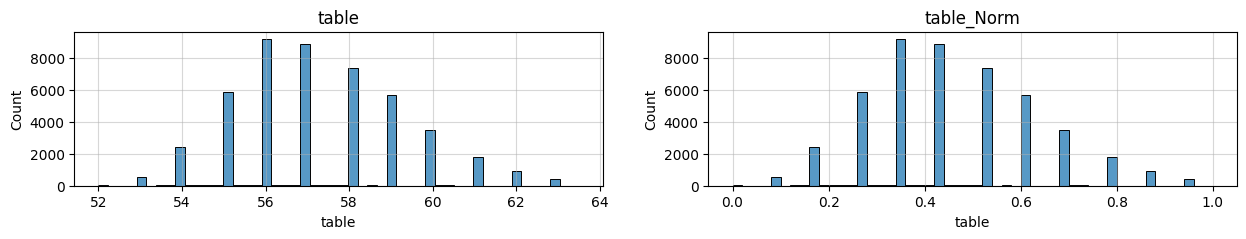

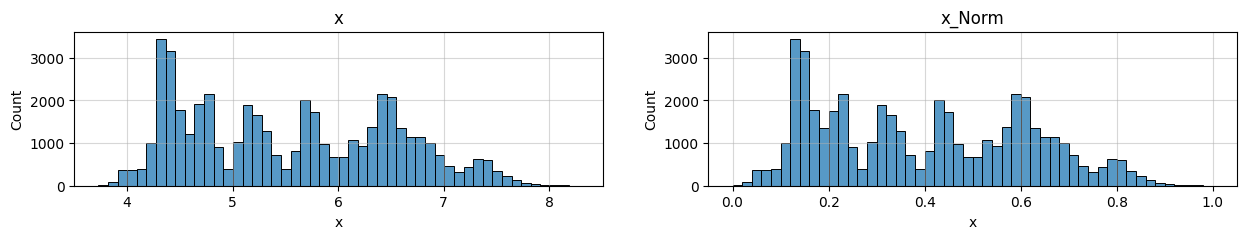

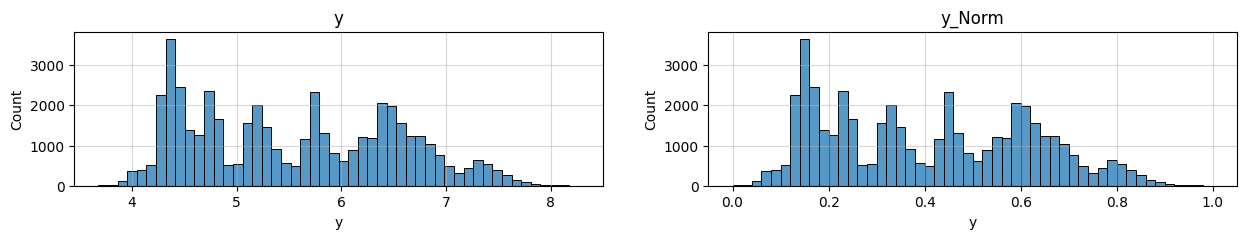

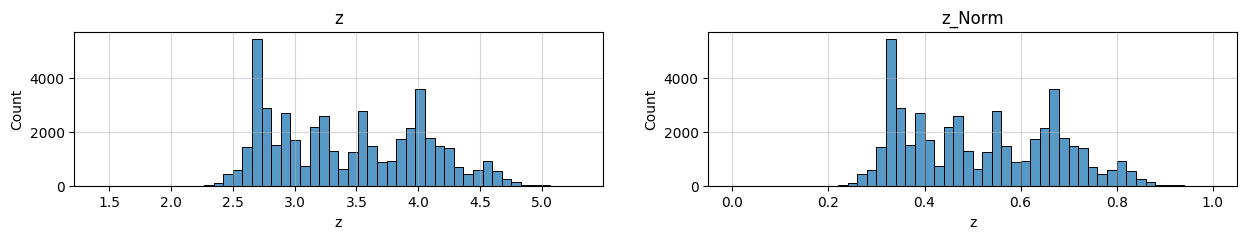

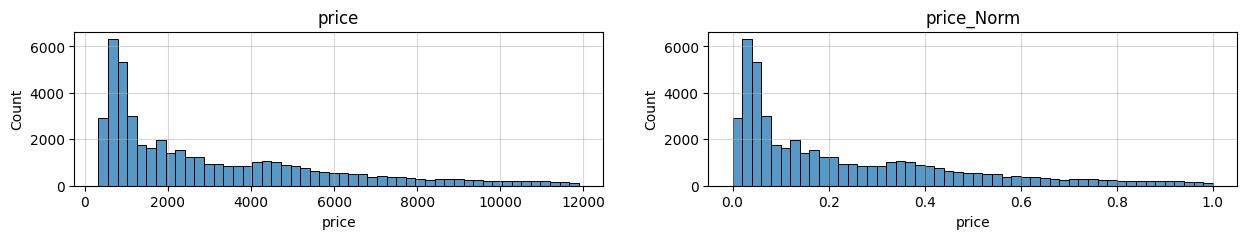

In [ ]:
for dfN in [dfXNorm, dfYNorm]:
    for i, colName in enumerate(dfN.columns ):
        #if df[colName].dtype == 'bool': continue
        plt.figure(figsize=(15, 2))

        plt.subplot(1, 2, 1)
        sns.histplot(df[colName], bins=50)
        plt.title(colName)
        plt.grid(True, alpha=0.5) # Сетка.

        plt.subplot(1, 2, 2)
        sns.histplot(dfN[colName], bins=50)
        plt.title(colName+"_Norm")
        plt.grid(True, alpha=0.5)  # Сетка.

##Формирование тренировочной и проверочной выборок

In [ ]:
valid_size = 0.2
rand_seed = 8

In [ ]:
xNorm_train, xNorm_test, yNorm_train, yNorm_test =  train_test_split(
    dfXNorm[features], # исходные данные X
    dfYNorm[target],   # исходные данные y
    test_size = valid_size, # доля тестовой части в выборке
    random_state = rand_seed,   # начальное состояние генератора случ. чисел
    shuffle=True               # перемешивание
)

index = int(len(xNorm_train) * 0.2)
xFor_pred = xNorm_train[:index]
yFor_pred = yNorm_train[:index]

xNorm_train = xNorm_train[index:]
yNorm_train = yNorm_train[index:]

In [ ]:
print(xNorm_train[:2])
print(yNorm_train[:2])

totalHistoryLossTrain=[] # Вспомогательный список для хранения полной истории обучения
totalHistoryLossTest=[]  # Вспомогательный список для хранения полной истории обучения

          carat   cut     color   clarity     depth     table         x  \
25330  0.127778  0.25  0.666667  0.285714  0.813559  0.086957  0.232967   
43620  0.166667  0.25  0.833333  0.714286  0.016949  0.782609  0.318681   

              y         z  
25330  0.250545  0.424165  
43620  0.331155  0.424165  
          price
25330  0.035720
43620  0.160612


###Структура и параметры

In [ ]:
def compile_model(add_layers:bool, feature):
  model = tf.keras.models.Sequential()

  # Входной слой
  model.add(tf.keras.layers.Input(shape=(len(feature),)))

  # Скрытые слои
  if add_layers:
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dense(32, activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='linear'))
  else:
    model.add(tf.keras.layers.Dense(1, activation='linear'))

  # Функции потерь и оптимизации
  fLoss=tf.keras.losses.MeanSquaredError()
  fOptimizer=tf.keras.optimizers.Adam(learning_rate=0.02)
  fMetricList = [tf.keras.losses.MeanSquaredError(), tf.keras.losses.MeanAbsoluteError()]

  model.compile(
      loss=fLoss,
      optimizer=fOptimizer,
      metrics=fMetricList
  )

  print(model.summary())

  return model

###Первичное и дополнительное обучение

In [ ]:
def fit_model_and_print_results(model, feature:list):
  totalHistoryLossTrain=[] # Вспомогательный список для хранения полной истории обучения
  totalHistoryLossTest=[]  # Вспомогательный список для хранения полной истории обучения
  history = model.fit(
    xNorm_train[feature],
    yNorm_train,
    validation_data=(
        xNorm_test[feature],
        yNorm_test
        ),
    epochs=20,
    batch_size=64,
    verbose=0
  )
  y_pred = model.predict(xFor_pred[feature])

  totalHistoryLossTrain.extend(history.history['loss'])
  if 'val_loss' in history.history.keys():
      totalHistoryLossTest.extend(history.history['val_loss'])

  plt.figure(figsize=(12,4))
  plt.plot(totalHistoryLossTrain, label='train', color = '#1f77b4')
  if 'val_loss' in history.history.keys():
      plt.plot(totalHistoryLossTest, label='test', color = '#ff7f0e')
  plt.title("История изменений выбраной оценки потерь (LossVal = mean_squared_error)")
  plt.ylabel("Оценка потерь (mean_squared_error)"); plt.xlabel("Эпохи обучения")
  plt.legend()
  plt.grid(True, alpha=0.5)  # Сетка

  y_mean = yNorm_train.mean()
  baseline_mse = np.mean((yNorm_test - y_mean) ** 2)
  baseline_mae = np.mean(np.abs(yNorm_test - y_mean))

  print(f"Изначальный MSE: {baseline_mse:.6f}")
  print(f"MSE (loss) модели после обучения: {history.history['val_loss'][-1]:.6f}")

  print(f"Изначальный MAE: {baseline_mae:.6f}")
  print(f"MAE модели после обучения: {history.history['val_mean_absolute_error'][-1]:.6f}")

  if len(feature) == 2:
     my3dplot (  xNorm_train, yNorm_train,  True,
                xNorm_test, yNorm_test, True,
                y_pred,            True,
                feature[0], feature[1], 'price',
                pointSize = 5,     # Размер точки
                pointTransparency  = 0.25, # Прозрачность точек графика train, test
                meshTransparency   = 0.5  # Прозрачность поверхности вычисленных значений y_pred
                )
  return y_pred


In [ ]:
print(xNorm_train[:2])
print(yNorm_train[:2])



          carat   cut     color   clarity     depth     table         x  \
25330  0.127778  0.25  0.666667  0.285714  0.813559  0.086957  0.232967   
43620  0.166667  0.25  0.833333  0.714286  0.016949  0.782609  0.318681   

              y         z  
25330  0.250545  0.424165  
43620  0.331155  0.424165  
          price
25330  0.035720
43620  0.160612


## Нейронная сеть M1. Построение модели без скрытых слоев и с признаками carat и color

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_11 (Dense)                │ (None, 1)              │             3 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3 (12.00 B)

 Trainable params: 3 (12.00 B)

 Non-trainable params: 0 (0.00 B)

None
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Изначальный MSE: 0.056605
MSE (loss) модели после обучения: 0.007805
Изначальный MAE: 0.193322
MAE модели после обучения: 0.060317


####################################################################################################
#### Имя слоя:dense_11;  Тип слоя: <class 'keras.src.layers.core.dense.Dense'> ##########
Вид ф-ии активации слоя: linear
Кол-во ВХодов  слоя: 2
Кол-во ВЫХодов слоя: 1
Кол-во нейронов слоя:    1

Весовые коэфф. weight_i_j=
[[1.1035049 ]
 [0.07533871]]

Весовые коэфф. bias_i_j=
[-0.11643297]




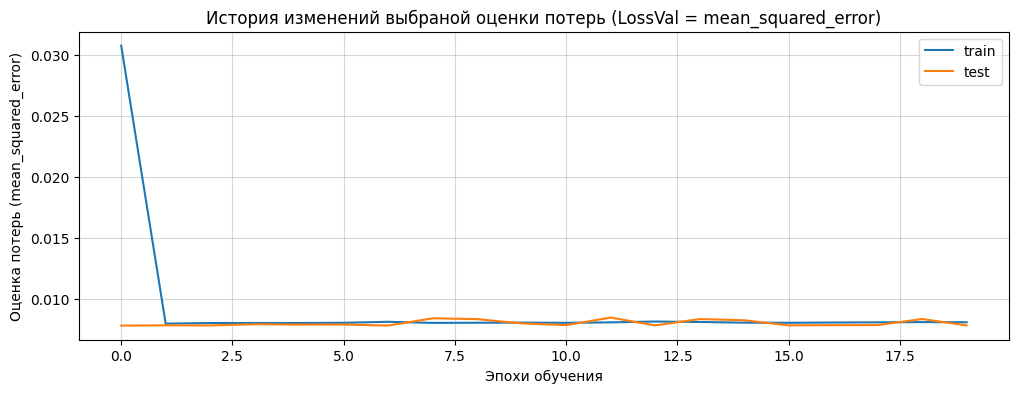

In [ ]:
M1 = compile_model(False, ['carat', 'color'])
M1_pred = fit_model_and_print_results(M1, ['carat', 'color'])

printModelWeights(M1)

In [ ]:
print_metrics(yFor_pred, M1_pred)
draw_plot(yFor_pred, M1_pred)

In [ ]:
my3dplot (  x_train: pd.DataFrame, y_train: pd.DataFrame,  isDrawTrain: bool,
                x_test:  pd.DataFrame, y_test: pd.DataFrame,    isDrawTest: bool,
                y_pred:  pd.DataFrame,            isDrawPred: bool,
                x1Name: str, x2Name: str, y_targetName: str,
                pointSize = 5,     # Размер точки
                pointTransparency  = 0.25, # Прозрачность точек графика train, test
                meshTransparency   = 0.5  # Прозрачность поверхности вычисленных значений y_pred
                )

## Нейронная сеть M2. Построение модели со скрытыми слоеями и с признаками carat и color

In [ ]:
M2 = compile_model(True, ['carat', 'color'])
M2_pred =fit_model_and_print_results(M2, ['carat', 'color'])

MAE :     0.049 (средняя абсолютная ошибка)
MSE :  0.006194 (среднеквадратичная ошибка)
RMSE:  0.078705 (кв. корень из среднеквадратичной ошибки)
R2  :     0.892 (коэфф. детерминации)


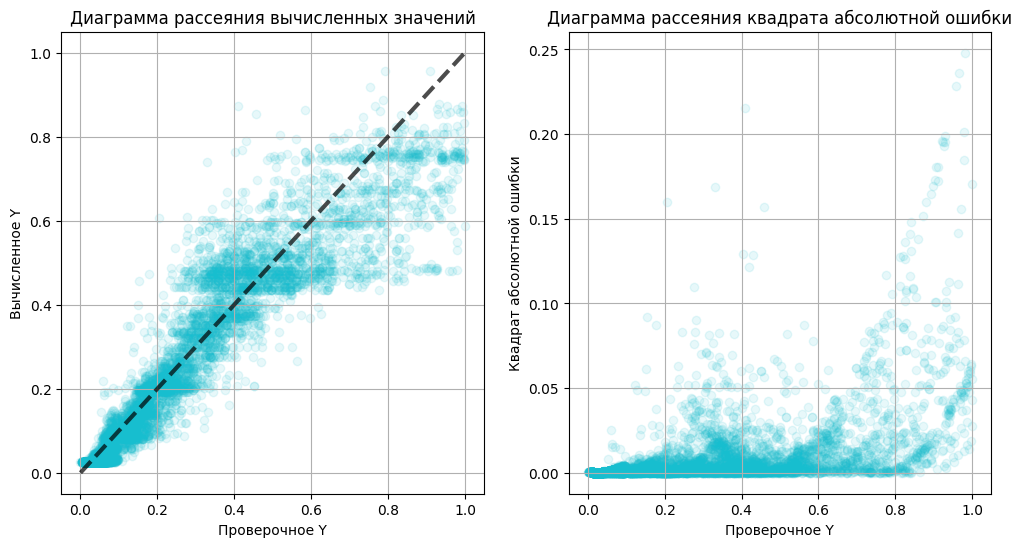

In [ ]:
print_metrics(yFor_pred, M2_pred)
draw_plot(yFor_pred, M2_pred)

## Нейронная сеть M3. Построение модели без скрытых слоев и со всеми признаками



In [ ]:
M3 = compile_model(False, features)
M3_pred =fit_model_and_print_results(M3, features)

In [ ]:
print_metrics(yFor_pred, M3_pred)
draw_plot(yFor_pred, M3_pred)

## Нейронная сеть M4. Построение модели со скрытыми слоями и со всеми признаками

In [ ]:
M4 = compile_model(True, features)
M4_pred =fit_model_and_print_results(M4, features)

In [ ]:
print_metrics(yFor_pred, M4_pred)
draw_plot(yFor_pred, M4_pred)

# Вывод

- Переход от простой линейной модели (M3) к более глубокой нелинейной (M4) почти вдвое уменьшил MAE и более чем в 3 раза уменьшил MSE, а коэффициент детерминации вырос примерно с 0.915 до 0.974. Это показывает, что добавление скрытых слоёв и большого числа нейронов позволило модели увеличить точность предсказанных значяений.
- Нейронная сеть на этом наборе данных показала себя эффективным инструментом регрессии, особенно при использовании всех доступных признаков и нелинейной архитектуры (M4).
- Разница в точности объясняется тем, что для данного набора данных простая линейная модель (M3) недостаточно выразительна, тогда как более глубокая нейросеть (M4) обладает достаточной сложностью, чтобы уловить нелинейные закономерности, но при этом не переобучается благодаря нормализации данных и разумному числу эпох.

In [ ]:
dfSpendTimeLab3 = pd.DataFrame.from_dict(
{
  "1": {"step": "Бизнес Анализ",                       "duration, min" : 15 },
  "2": {"step": "Анализ данных",                       "duration, min" : 25 },
  "3": {"step": "Подготовка данных",                   "duration, min" : 40 },
  "4": {"step": "Моделирование (Обуч.и подг.)",        "duration, min" : 35 },
  "5": {"step": "Моделирование (Оценка кач. моделей)", "duration, min" : 20 },
  "6": {"step": "Оценка решения + Внедрение",          "duration, min" : 10 },
}
, orient="index"
).sort_index(ascending=False)
# Построить столбчатую диаграмму
fig = plt.figure()
plt.barh(y = dfSpendTimeLab3["step"], width= dfSpendTimeLab3["duration, min"], )
plt.xlabel("Затраченное время, мин")

# Построить круговую диаграмму
fig = plt.figure()
plt.pie(x= dfSpendTimeLab3["duration, min"], labels=dfSpendTimeLab3["step"],  startangle = 90 )

plt.show()